In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Select image patches for processing

In this short chapter we will start working on mosaic composing. Before
we will start working on matching algorithm, we have to prepare processing
framework.

We will be working on `MosaicImage` class from `mosaic_maker.mosaic.mosaic_image`
module.

We have two methods to implement there:
  - `_crop_image_to_patch_size`, that crops image so its completely divisable
  by our patch size - this is brutal solution that will save us from 
  border-case headaches
  - `_select_patch_for`, that will use a `PatchPicker` class for selecting
  match for currently processed square and will print patch on mosaic image.
  On top of that, `_select_patch_for` prints some development info.
  
Displaying development info on images is common practice for debugging and
tracking computer vision algorithms behavior. In our case we will display
Sobel version of image and mosaic to see if our algorithm persists general
edges. We will also mark current progress by marking processed shapes with 
rectangles.

Take a while for `MosaicImage` implementation analysis. As you will see we're
using threads for its main loop. The reason is that we want to be able to
display current mosaic composing status while we are doing computation-heavy
operations. In order to prevent mosaic computation from blocking interface
we put its logic to separate thread witch is quite common practice when
creating systems with responsive GUI.

Let's start simple with cropping implementation. At this stage you
should be acquainted with numpy enough to crop source image so its
fully divisible by the `PATCH_SIZE`. 

Remember to make `select_patch_for` return new image instead of 
modifying original image.
  

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mosaic_maker.mosaic.mosaic_image import MosaicImage
from mosaic_maker.mosaic.patch_picker import PatchPicker
from config import PATCH_SIZE, PROJECT_ROOT

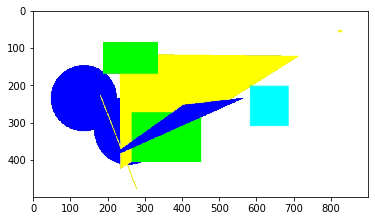

In [17]:
image_path = PROJECT_ROOT / 'assets/test-target.jpg'
test_image = cv2.imread(image_path.as_posix())
plt.imshow(test_image)


original shape: (500, 900, 3)
cropped shape: (480, 896, 3)


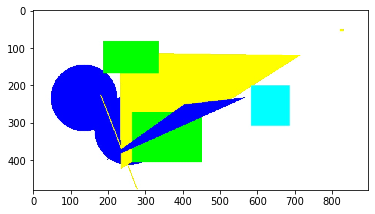

In [18]:
test_image_copy = test_image.copy()

cropped_image = MosaicImage._crop_image_to_patch_size(test_image_copy, PATCH_SIZE)
print(f'original shape: {test_image_copy.shape}')
print(f'cropped shape: {cropped_image.shape}')
plt.imshow(cropped_image)

The next step will be a bit more sophisticated. We want to modify 
`_select_patch_for` method so it:
  - creates patch class instance for provided `(x, y)` position
  - feeds it to patch picker `pick_patch_for` method to select mosaic patch
   (currently `pick_patch_for` isn't implemented, so it always returns a random
   image from the sources set
  - prints corresponding images on `mosaic` and `sobel_mosaic`
  - prints corresponding rectangles on `target_image_copy` and `target_sobel_image_copy`

In [19]:
test_image_copy = test_image.copy()

patches_path = PROJECT_ROOT / 'assets/indexed-sources/test'
patch_picker = PatchPicker('test', patches_path)
mosaic_image = MosaicImage(test_image_copy, PATCH_SIZE, patch_picker)

In [20]:
mosaic = np.zeros(mosaic_image.target_image.shape, np.uint8)
sobel_mosaic = np.zeros(mosaic_image.target_sobel_image.shape, np.uint8)


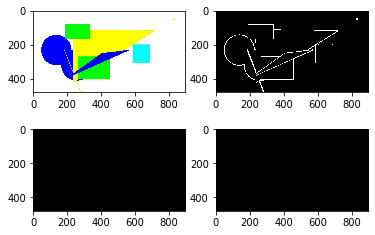

In [21]:
_, grid = plt.subplots(2, 2)
grid[0, 0].imshow(mosaic_image.target_image)
grid[0, 1].imshow(mosaic_image.target_sobel_image, cmap='gray')
grid[1, 0].imshow(mosaic)
grid[1, 1].imshow(sobel_mosaic, cmap='gray')

In [22]:
target_image_copy = mosaic_image.target_image.copy()
target_sobel_image_copy = mosaic_image.target_sobel_image.copy()

(height, width) = target_image_copy.shape[:2]
mosaic_image._compose_mosaic_for(width, height, 
                                 mosaic, sobel_mosaic, 
                                 target_image_copy, target_sobel_image_copy)


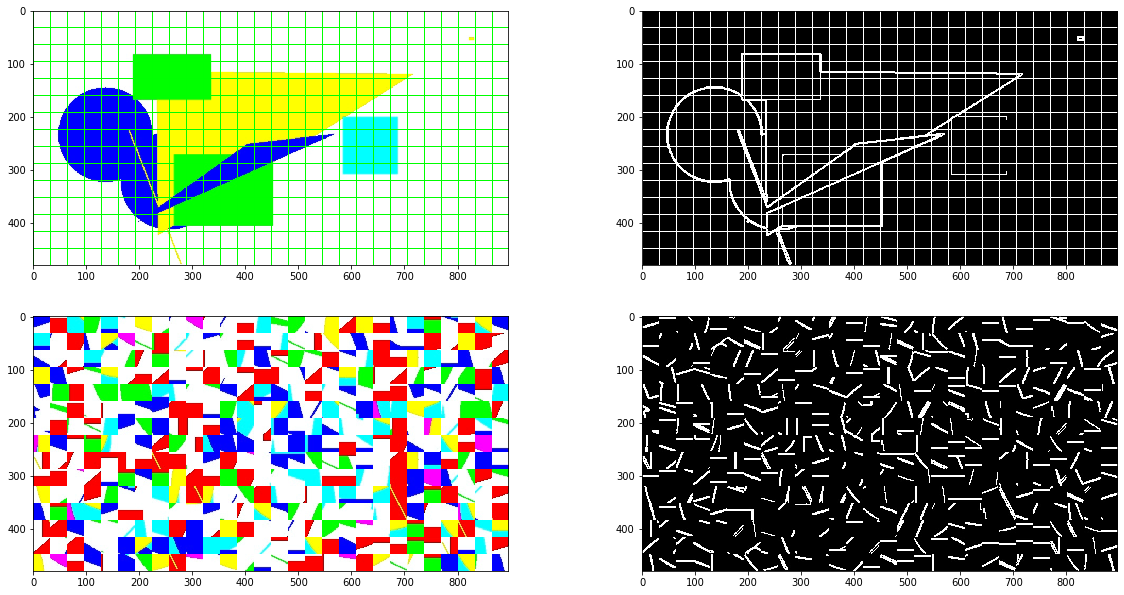

In [27]:
_, grid = plt.subplots(2, 2, figsize=(20, 10.3))
grid[0, 0].imshow(target_image_copy)
grid[0, 1].imshow(target_sobel_image_copy, cmap='gray')
grid[1, 0].imshow(mosaic)
grid[1, 1].imshow(sobel_mosaic, cmap='gray')

The result should similar to this:

![title](assets/3-select-image/result.png)

Grid may not display fully depending on the shource image size due to
matplotlib compression.

If you'll run `compose_mosaic` module main function, you should see mosaic
filling up dynamically resulting in the following windows displayed:

![title](assets/3-select-image/modals-result.png)

